In [14]:
# in this project we perform SKU forecasting on a sales dataset. the available features are: order_number, order_date, customer_number, type, month, item_number (SKU), quantity, category, revenue, customer_source, order_source

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [16]:
# load the dataset
df = pd.read_csv('data/sales.csv')
df.head()


,order_number,order_date,customer_number,type,month,item_number,quantity,category,revenue,customer_source,order_source
0,KE0001,2024-01-01,CKE0539,RETAIL,2024-01,KE0895,12,DIABETES,5.098618,direct,App
1,KE0001,2024-01-01,CKE0539,RETAIL,2024-01,KE1000,23,HYPERTENSIVES,12.460205,direct,App
2,KE0001,2024-01-01,CKE0539,RETAIL,2024-01,KE0921,12,HYPERTENSIVES,8.012194,direct,App
3,KE0002,2024-01-01,CKE0580,WHOLESALE,2024-01,KE0015,23,DIABETES,13.854194,agent,call
4,KE0002,2024-01-01,CKE0580,WHOLESALE,2024-01,KE0224,21,HYPERTENSIVES,10.534678,agent,call


In [17]:
# remove unnecessary columns
df = df.drop(['order_number', 'customer_number', 'type', 'month', 'category', 'revenue', 'customer_source', 'order_source'], axis=1)
df.head()

,order_date,item_number,quantity
0,2024-01-01,KE0895,12
1,2024-01-01,KE1000,23
2,2024-01-01,KE0921,12
3,2024-01-01,KE0015,23
4,2024-01-01,KE0224,21


In [18]:
# chck how many data points we have for each product and their total revenue. get the top 5 and the bottom 5 in the list and analyse them
print(df['item_number'].value_counts().head(5))
print(df['item_number'].value_counts().tail(5))


item_number
KE0818    85
KE0363    84
KE0494    82
KE0914    82
KE0258    82
Name: count, dtype: int64
item_number
KE0523    42
KE0360    41
KE0665    40
KE0092    39
KE0741    37
Name: count, dtype: int64


In [19]:
df.dtypes

order_date     object
item_number    object
quantity        int64
dtype: object

In [23]:
# convert order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# create week column 
df['week'] = df['order_date'].dt.isocalendar().week
df.head(5)

,order_date,item_number,quantity,week
0,2024-01-01,KE0895,12,1
1,2024-01-01,KE1000,23,1
2,2024-01-01,KE0921,12,1
3,2024-01-01,KE0015,23,1
4,2024-01-01,KE0224,21,1


In [26]:
# aggregate the data by week and item_number
df = df.groupby(['week', 'item_number']).agg({'quantity':'sum'}).reset_index()
print(df.head(5))
print('\n df shape:', df.shape)

   week item_number  quantity
0     1      KE0001         5
1     1      KE0002        11
2     1      KE0003        16
3     1      KE0004        39
4     1      KE0006        17

 df shape: (26062, 3)


In [30]:
# print weekly sales for KE0001
df_ke0001 = df[df['item_number'] == 'KE0001'] 
print(df_ke0001)

       week item_number  quantity
0         1      KE0001         5
875       2      KE0001        19
1748      3      KE0001        30
2625      4      KE0001         5
5237      7      KE0001        15
6124      8      KE0001       137
6982      9      KE0001        41
7846     10      KE0001        18
8730     11      KE0001        55
9611     12      KE0001        40
10477    13      KE0001        18
11358    14      KE0001        24
12240    15      KE0001        29
13997    17      KE0001        29
14890    18      KE0001        36
15773    19      KE0001        41
16642    20      KE0001        51
17528    21      KE0001        86
19305    23      KE0001        26
20179    24      KE0001       100
21061    25      KE0001        13
22817    27      KE0001        18
25453    30      KE0001        59


In [31]:
# the data is not continuous, we need to fill in the missing weeks with 0 sales
weeks = df['week'].unique()
items = df['item_number'].unique()
df = df.set_index(['week', 'item_number']).reindex(pd.MultiIndex.from_product([weeks, items], names=['week', 'item_number'])).reset_index()
df['quantity'] = df['quantity'].fillna(0)

In [32]:
df_ke0001 = df[df['item_number'] == 'KE0001'] 
print(df_ke0001)

       week item_number  quantity
0         1      KE0001       5.0
1000      2      KE0001      19.0
2000      3      KE0001      30.0
3000      4      KE0001       5.0
4000      5      KE0001       0.0
5000      6      KE0001       0.0
6000      7      KE0001      15.0
7000      8      KE0001     137.0
8000      9      KE0001      41.0
9000     10      KE0001      18.0
10000    11      KE0001      55.0
11000    12      KE0001      40.0
12000    13      KE0001      18.0
13000    14      KE0001      24.0
14000    15      KE0001      29.0
15000    16      KE0001       0.0
16000    17      KE0001      29.0
17000    18      KE0001      36.0
18000    19      KE0001      41.0
19000    20      KE0001      51.0
20000    21      KE0001      86.0
21000    22      KE0001       0.0
22000    23      KE0001      26.0
23000    24      KE0001     100.0
24000    25      KE0001      13.0
25000    26      KE0001       0.0
26000    27      KE0001      18.0
27000    28      KE0001       0.0
28000    29   

In [37]:
unique_items = df['item_number'].unique()

unique_items[:5]

array(['KE0001', 'KE0002', 'KE0003', 'KE0004', 'KE0006'], dtype=object)

In [44]:
# time series prediction model for df_ke0001 using ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# split the data into train and test
train = df_ke0001[df_ke0001['week'] <= 25]
test = df_ke0001[df_ke0001['week'] > 25]

# fit the model
model = ARIMA(train['quantity'], order=(5,1,0))
model_fit = model.fit()


/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Test RMSE: 31.959


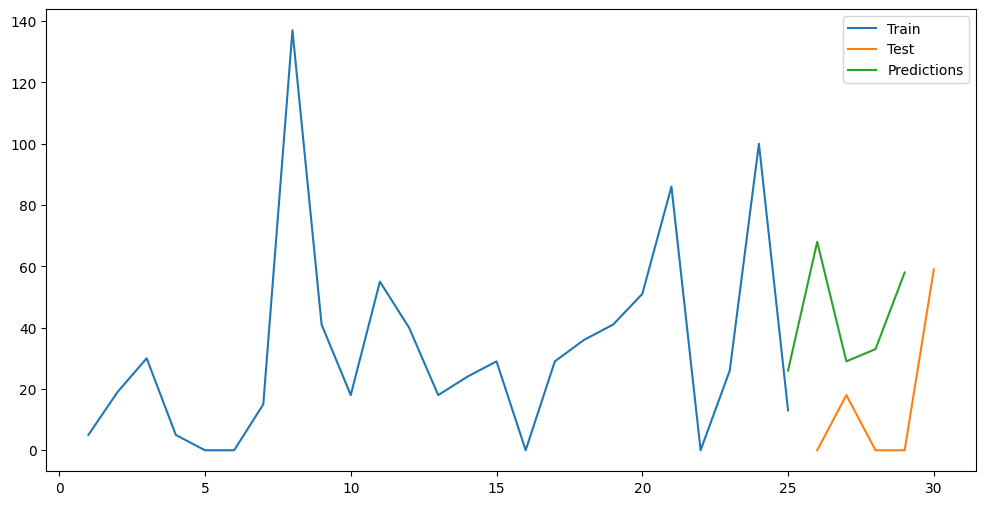

In [45]:
# make predictions
predictions = model_fit.forecast(steps=len(test))
predictions = predictions.reset_index()
predictions.columns = ['week', 'quantity']
predictions['item_number'] = 'KE0001'
predictions['week'] = predictions['week'].astype(int)
predictions['quantity'] = predictions['quantity'].astype(int)

# calculate the RMSE
rmse = sqrt(mean_squared_error(test['quantity'], predictions['quantity']))
print('Test RMSE: %.3f' % rmse)

# plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['week'], train['quantity'], label='Train')
plt.plot(test['week'], test['quantity'], label='Test')
plt.plot(predictions['week'], predictions['quantity'], label='Predictions')
plt.legend()
plt.show()


In [48]:
# train new model on all 30 weeks of data
model = ARIMA(df_ke0001['quantity'], order=(5,1,0))
model_fit = model.fit()


/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


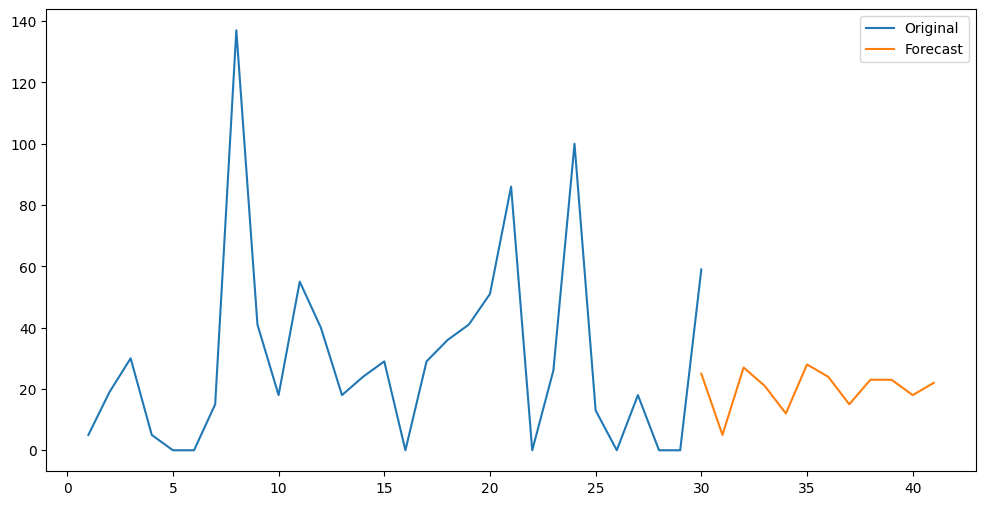

In [49]:
# predictthe data for next 12 weeks starting from week 31
# plot the original data till 30 weeks and the forecasted data for the next 12 weeks
predictions = model_fit.forecast(steps=12)
predictions = predictions.reset_index()
predictions.columns = ['week', 'quantity']
predictions['item_number'] = 'KE0001'
predictions['week'] = predictions['week'].astype(int)
predictions['quantity'] = predictions['quantity'].astype(int)

plt.figure(figsize=(12, 6))
plt.plot(df_ke0001['week'], df_ke0001['quantity'], label='Original')
plt.plot(predictions['week'], predictions['quantity'], label='Forecast')
plt.legend()
plt.show()



In [58]:
# repeat the same process but instead of considering weeks, consider days for the same item KE0001
df = pd.read_csv('data/sales.csv')
df = df.drop(['order_number', 'customer_number', 'type', 'month', 'category', 'revenue', 'customer_source', 'order_source'], axis=1)
df['order_date'] = pd.to_datetime(df['order_date'])
df['day'] = df['order_date'].dt.day_of_year

print(df.shape)
df.head()


(61800, 4)


,order_date,item_number,quantity,day
0,2024-01-01,KE0895,12,1
1,2024-01-01,KE1000,23,1
2,2024-01-01,KE0921,12,1
3,2024-01-01,KE0015,23,1
4,2024-01-01,KE0224,21,1


In [59]:
# unique days count
print(df['day'].nunique())

206


In [60]:
# the data is not continuous, we need to fill in the missing days with 0 sales
days = df['day'].unique()
items = df['item_number'].unique()
df = df.groupby(['day', 'item_number']).agg({'quantity':'sum'}).reset_index()
df = df.set_index(['day', 'item_number']).reindex(pd.MultiIndex.from_product([days, items], names=['day', 'item_number'])).reset_index()
df['quantity'] = df['quantity'].fillna(0)

print(df['day'].nunique())


206


In [61]:
# get the data for item KE0001
df_ke0001 = df[df['item_number'] == 'KE0001']
print(df_ke0001)

        day item_number  quantity
866       1      KE0001       0.0
1866      2      KE0001       0.0
2866      3      KE0001       0.0
3866      4      KE0001       0.0
4866      5      KE0001       0.0
...     ...         ...       ...
201866  202      KE0001       0.0
202866  203      KE0001       0.0
203866  204      KE0001       0.0
204866  205      KE0001      11.0
205866  206      KE0001      48.0

[206 rows x 3 columns]


In [62]:
# now we train the ARIMA model on the daily data for item KE0001
train = df_ke0001[df_ke0001['day'] <= 180]
test = df_ke0001[df_ke0001['day'] > 180]

model = ARIMA(train['quantity'], order=(5,1,0))
model_fit = model.fit()

/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/naveenmalla/Documents/Projects/Kasha/Customer-Segmentation-and-SKU-Forecasting/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Test RMSE: 10.283


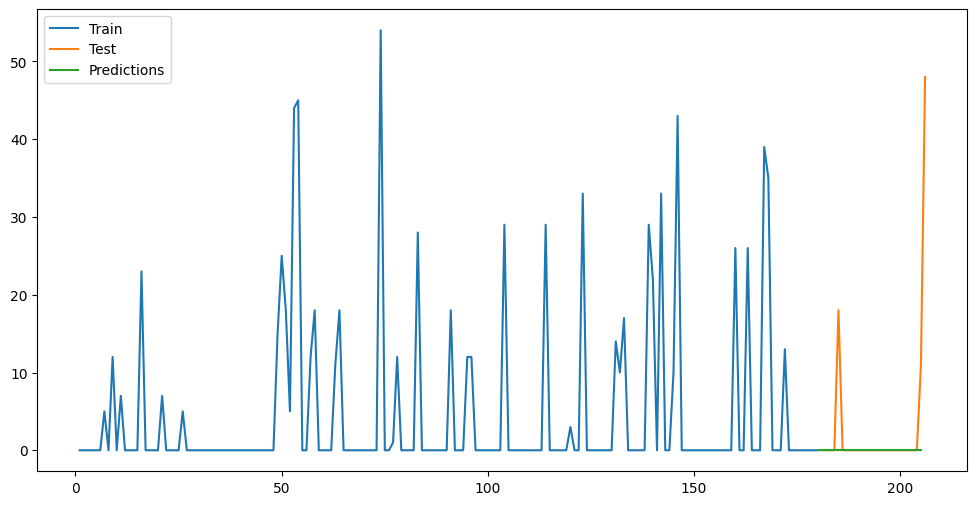

In [63]:
# make predictions
predictions = model_fit.forecast(steps=len(test))
predictions = predictions.reset_index()
predictions.columns = ['day', 'quantity']
predictions['item_number'] = 'KE0001'
predictions['day'] = predictions['day'].astype(int)

# calculate the RMSE
rmse = sqrt(mean_squared_error(test['quantity'], predictions['quantity']))
print('Test RMSE: %.3f' % rmse)

# plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['day'], train['quantity'], label='Train')
plt.plot(test['day'], test['quantity'], label='Test')
plt.plot(predictions['day'], predictions['quantity'], label='Predictions')
plt.legend()
plt.show()
